In [2]:
import qiskit
import torch
import sympy
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import BCELoss

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Linear,
    Sequential,
    ReLU,
    Sigmoid,
)
import torch.nn.functional as F
from torchsummary import summary
import datetime
from tools_main import *
from random import shuffle


algorithm_globals.random_seed = 42

In [3]:
def create_qnn(n_layers=1, n_qubits=4):
    qreg_q = QuantumRegister(n_qubits, 'q')

    IEC = QuantumCircuit(qreg_q)
    PQC = QuantumCircuit(qreg_q)
    
    paramsx = ParameterVector('x',n_qubits)
    for i,param in enumerate(paramsx):
        IEC.ry(param,i)
    
    paramsθ = ParameterVector('θ',n_qubits*(n_layers+1))
    for i in range(n_qubits):
        PQC.ry(paramsθ[i],i)
    for layer in range(n_layers):
        for i in range(n_qubits):
            PQC.cz(n_qubits-2-i%n_qubits, n_qubits-1-i%n_qubits)
        PQC.barrier()
        for i in range(n_qubits):
            PQC.ry(paramsθ[i+n_qubits*(layer+1)],i)
    
    qc = QuantumCircuit(qreg_q)
    qc.compose(IEC,inplace=True)
    qc.compose(PQC,inplace=True)
    #qc.measure_all()
    
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=IEC.parameters,
        weight_params=PQC.parameters,
        input_gradients=True,
        )
    
    return qnn



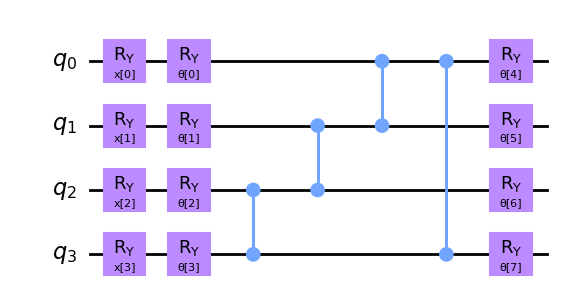

In [4]:
qnn = create_qnn()
qnn.circuit.draw('mpl',plot_barriers = False)

In [5]:
class Rescale01(Module):
    def __init__(self, name='Rescale01'):
        super(Rescale01, self).__init__()

    def forward(self, X):
        X = torch.divide(
                torch.subtract(
                    X, 
                    torch.min(X)
                ), 
                torch.subtract(
                    torch.max(X), 
                    torch.min(X)
                ),
            
        )
        return X

In [6]:

class EdgeNet(Module):
    def __init__(self, name='EdgeNet'):
        
        super().__init__()
        
        self.name = name
        self.n_layers = 1
        self.n_qubits = 4
        
         
        # Classical input layer of the Node Network
        # takes input data and feeds it to the QNN layer
        self.input_layer = Linear(2*(3+self.n_qubits),self.n_qubits)
        self.relu = ReLU()
        self.rescale = Rescale01()
        
        # Intitialize QNN and weights
        # Turn QNN into torch layer
        
        qnn = create_qnn()
        initial_weights = 2*np.pi*algorithm_globals.random.random(qnn.num_weights)
        self.qnn = TorchConnector(qnn, initial_weights = initial_weights)

        # Classical readout layer
        self.readout_layer = Linear(1,1)
        self.sigmoid = Sigmoid()

       
    def forward(self,X, Ri, Ro):
        '''forward pass of the edge network. '''

        # Construct the B matrix
        bo = torch.matmul(torch.t(Ro),X)
        bi = torch.matmul(torch.t(Ri),X)
        B  = torch.concat([bo, bi], dim=1)
        # Shape of B = N_edges x 6 (2x (3 + Hidden Dimension Size))
        # each row consists of two node that are connected in the input graph.
        
        
        # Scale the output to be [0,PI]
        # this value is a preference and can be changed 
        x = self.input_layer(B) * np.pi
        #print(f"Edge input size: {x.shape}")
        x = self.relu(x)
        x = self.rescale(x)
        
        x = self.qnn(x)   
        #print(f"Edge qnn size {x.shape}")
        
        x = self.readout_layer(x)
        #print(f"Edge readout size: {x.shape}")
        x = self.sigmoid(x)
        # Return the output of the final layer
       
        return x
    


EdgeNet()

EdgeNet(
  (input_layer): Linear(in_features=14, out_features=4, bias=True)
  (relu): ReLU()
  (rescale): Rescale01()
  (qnn): TorchConnector()
  (readout_layer): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
class NodeNet(Module):
    def __init__(self, name='NodeNet'):
        super().__init__()
        #super(NodeNet, self).__init__(name=name)
        
        self.n_layers = 1
        self.n_qubits = 4

       
        # Classical input layer of the Node Network
        self.input_layer = Linear(3*(3+self.n_qubits),self.n_qubits)
        self.relu = ReLU()
        self.rescale = Rescale01()
       
        # Read the Quantum Circuit with specified configuration
        # Create pytorch module
        qnn = create_qnn()
        initial_weights = 2*np.pi*algorithm_globals.random.random(qnn.num_weights)
        self.qnn = TorchConnector(qnn,initial_weights=initial_weights)
        
        self.quantum_out = Linear(1,4)
        self.relu1 = ReLU()
        self.readout_layer = Linear(4,4)
        self.relu2 = ReLU()
        # Classical readout layer
        

    def forward(self, X, e, Ri, Ro):

        # The following lines constructs the M matrix
        # M matrix contains weighted averages of input and output nodes
        # the weights are the edge probablities.
        bo  = torch.matmul(torch.t(Ro), X)
        bi  = torch.matmul(torch.t(Ri), X) 
        Rwo = Ro * e[:,0]
        Rwi = Ri * e[:,0]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        # mi: weighted average of input nodes
        # mo: weighted average of output nodes
        
        M = torch.concat([mi, mo, X], dim=1)
           
        # Scale the output to be [0,PI]
        # this value is a preference and can be changed 
        x = self.input_layer(M)
        x = self.relu(x)
        x = self.rescale(x)

        # Feed to qnn
        x = self.qnn(x)  
        
        #fully connected layer to change shape
        x = self.quantum_out(x)
        x = self.relu1(x)
        
        # Return the output of the final layer
        x = self.readout_layer(x)
        x = self.relu2(x)
        
        return x
NodeNet()

NodeNet(
  (input_layer): Linear(in_features=21, out_features=4, bias=True)
  (relu): ReLU()
  (rescale): Rescale01()
  (qnn): TorchConnector()
  (quantum_out): Linear(in_features=1, out_features=4, bias=True)
  (relu1): ReLU()
  (readout_layer): Linear(in_features=4, out_features=4, bias=True)
  (relu2): ReLU()
)

In [8]:
class GNN(Module):
    def __init__(self):
        ''' Init function of GNN, inits all GNN blocks. '''
        super(GNN, self).__init__()
       
        self.n_qubits=4
        # Define Initial Input Layer
        self.InputNet = Linear(3, self.n_qubits)
        self.relu = ReLU()
        self.EdgeNet  = EdgeNet()
        self.NodeNet  = NodeNet()
        self.n_iters  = 1
        
    def forward(self, graph_array):
        ''' forward pass of the GNN '''
        # decompose the graph array
        X, Ri, Ro = graph_array
        
        # execute InputNet to produce hidden dimensions
        H = self.InputNet(X)
        H = self.relu(H)
        
        # add new dimensions to original X matrix
        H = torch.concat([H,X],dim=1)
        
        # recurrent iteration of the network
        for i in range(self.n_iters):
            
            e = self.EdgeNet(H, Ri, Ro)
      
            H = self.NodeNet(H, e, Ri, Ro)
            
            # update H with the output of NodeNet
            H = torch.concat([H,X],dim=1)
            
        # execute EdgeNet one more time to obtain edge predictions

        e = self.EdgeNet(H, Ri, Ro)
        
        # return edge prediction array
        return e
    
GNN()

GNN(
  (InputNet): Linear(in_features=3, out_features=4, bias=True)
  (relu): ReLU()
  (EdgeNet): EdgeNet(
    (input_layer): Linear(in_features=14, out_features=4, bias=True)
    (relu): ReLU()
    (rescale): Rescale01()
    (qnn): TorchConnector()
    (readout_layer): Linear(in_features=1, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (NodeNet): NodeNet(
    (input_layer): Linear(in_features=21, out_features=4, bias=True)
    (relu): ReLU()
    (rescale): Rescale01()
    (qnn): TorchConnector()
    (quantum_out): Linear(in_features=1, out_features=4, bias=True)
    (relu1): ReLU()
    (readout_layer): Linear(in_features=4, out_features=4, bias=True)
    (relu2): ReLU()
  )
)

In [10]:
n_epochs = 3
n_train = 50
batch_size = 1

model = GNN()
model.train()

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = BCELoss()

train_data = get_dataset('data/train', n_train)
train_list = [i for i in range(50)]

loss_list = []
print("Starting Training")
#torch.autograd.detect_anomaly()
for epoch in range(n_epochs):
    
    shuffle(train_list) # shuffle the order every epoch
    
    for batch in range(n_train):
            # start timer
        t0 = datetime.datetime.now()  
        
        
        X, Ri, Ro, y = train_data[train_list[batch]]

        X = torch.tensor(map2angle(X))
        Ri = torch.tensor(Ri)
        Ro = torch.tensor(Ro)
        labels = torch.reshape(torch.tensor(y),shape=(y.shape[0],1))
        
        optimizer.zero_grad()
        
        
        #calculate weight for each edge to avoid class imbalance
        #weights = torch.tensor(true_fake_weights(y))
        #reshape weights
        #weights = torch.reshape(weights, shape=(weights.shape[0],1))
        
        #forward pass
        
        preds = model([X,Ri,Ro])
        
        for i in preds:
            if i == 0:
                i = 1e-8
       
        print(f"Preds {preds}")
        
        
        t0_loss = datetime.datetime.now()
        
        loss = loss_func(preds, labels)
        
        print(f"loss {loss}")
        
        dt_loss = datetime.datetime.now() - t0_loss 
        t_loss = dt_loss.seconds
        
        print(f"BCELoss time: {t_loss//60}m{t_loss%60}s")
        
        
        t0_back = datetime.datetime.now()
        
        loss.backward()
        
        dt_back = datetime.datetime.now() - t0_back 
        t_back = dt_back.seconds
        
        print(f"Back Prop time: {t_back//60}m{t_back%60}s")
        
        
        t0_opt = datetime.datetime.now()
        
        optimizer.step()
        
        dt_opt = datetime.datetime.now() - t0_opt 
        t_opt = dt_opt.seconds 
        
        print(f"optimizer time: {t_opt//60}m{t_opt%60}s")   

    
        loss_list.append(loss.item())                
            
        dt = datetime.datetime.now() - t0  
        t = dt.seconds

            # Print summary
        print(
            ": Epoch: %d, Batch: %d, Loss: %.4f, Elapsed: %dm%ds" \
            %(epoch+1, batch+1, loss.item() ,t / 60, t % 60)
            )
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name, param.data)

Starting Training
Preds tensor([[0.3242],
        [0.3242],
        [0.3242],
        ...,
        [0.3234],
        [0.3249],
        [0.3264]], grad_fn=<SigmoidBackward0>)
loss 0.7970899939537048
BCELoss time: 0m0s
Back Prop time: 7m32s
optimizer time: 0m0s
: Epoch: 1, Batch: 1, Loss: 0.7971, Elapsed: 7m52s
InputNet.weight tensor([[ 0.5382, -0.2134,  0.0223],
        [ 0.0239, -0.4135, -0.1262],
        [ 0.1738, -0.5295, -0.4258],
        [-0.0900, -0.1145,  0.4364]])
InputNet.bias tensor([ 0.4021,  0.1905, -0.4611,  0.5413])
EdgeNet.input_layer.weight tensor([[ 0.1388,  0.1716,  0.1258,  0.1037, -0.2221, -0.0152, -0.0167, -0.0216,
          0.2426,  0.0791,  0.0086,  0.2273,  0.1813, -0.1498],
        [ 0.2464,  0.0153, -0.1817,  0.2327,  0.1717,  0.0579, -0.2514, -0.1053,
          0.1709,  0.2380,  0.2469, -0.1339, -0.0821, -0.1031],
        [-0.2268,  0.0523,  0.1114,  0.1179,  0.1730, -0.0853,  0.2099,  0.0217,
          0.2297, -0.0548,  0.2419,  0.0428, -0.0688,  0.0141],
   

KeyboardInterrupt: 

In [20]:

train_data = get_dataset('data/train', 50)
train_list = [i for i in range(50)]

X, Ri, Ro, y = train_data[0]

X = torch.tensor(map2angle(X))
Ri = torch.tensor(Ri)
Ro = torch.tensor(Ro)
labels = torch.reshape(torch.tensor(y),shape=(y.shape[0],1))

print(X.shape, Ri.shape, Ro.shape,labels.shape)
count = 0 


torch.Size([3297, 3]) torch.Size([3297, 4730]) torch.Size([3297, 4730]) torch.Size([4730, 1])


In [10]:

# #ignore

#     def batch_train_step(n_step):
#         batch_size = 1
#         '''combines multiple  graph inputs and executes a step on their mean'''
#         for batch in range(batch_size):
#             X, Ri, Ro, y = train_data[
#                 train_list[n_step*batch_size+batch]
#                 ]

#             X = torch.tensor(map2angle(X))
#             Ri = torch.tensor(Ri)
#             Ro = torch.tensor(Ro)
#             label = torch.reshape(torch.tensor(y),shape=(y.shape[0],1))

#             if batch==0:
#                 # calculate weight for each edge to avoid class imbalance
#                 weights = torch.tensor(true_fake_weights(y))
#                 # reshape weights
#                 weights = torch.reshape(weights,
#                                      shape=(weights.shape[0],1))
#                 preds = model([X,Ri,Ro])
#                 labels = label
#     #             else:
#     #                 weight = torch.tensor(true_fake_weights(y))
#     #                 # reshape weights
#     #                 weight = torch.reshape(tf.torchtensor(weight),
#     #                                     shape=(weight.shape[0],1))

#     #                 weights = torch.concat([weights, weight],axis=0)
#     #                 preds = torch.concat([preds, model([map2angle(X),Ri,Ro])],axis=0)
#     #                 labels = torch.concat([labels, label],axis=0)
#             loss_func = BCELoss(weight=weights)
#             loss = loss_func(labels, preds)


#             loss.backward()
#             optimizer.step()

#         return loss.item()
